<a href="https://colab.research.google.com/github/shariar26868/Ai-task-for-Job-Interview/blob/main/AI_Task_Md_Shariar_Emon_Shaikat_SET_A_semonshaikat702_gmail_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project focuses on developing a machine learning model to classify question pairs as either "duplicate" or "not duplicate" based on semantic similarity. By leveraging natural language processing (NLP) techniques and deep learning models such as LSTMs, GRUs, or transformer-based architectures, the goal is to improve text similarity detection for better understanding of duplicate questions. The project involves exploratory data analysis (EDA), text preprocessing, model building, evaluation, and optimization to achieve high classification accuracy.


# Importing the necessary module for my task

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC

# Mounting drive for access the dataset

In [4]:
from google import colab
colab.drive.mount('/content/drive')

Mounted at /content/drive


Putting the drive path in a 'dataset' variable

In [5]:
datasetPath= pd.read_csv("/content/drive/My Drive/AI task/train.csv")

Ensure my dataset in drive or not

In [6]:
import os
print(os.path.exists("drive/My Drive/AI task/train.csv"))


True


In [7]:
dataset=pd.read_csv("/content/drive/My Drive/AI task/train.csv")

For reproductivity we are taking 10 thousand data for our task

In [8]:
dataset = dataset.sample(n=10000, random_state=42)

In [9]:
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


Create some dummy variable where I copying the dataset two times for further work

In [10]:
dataset1=dataset.copy()
dataset2=dataset.copy()

# Exploratory Data Analysis

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 8067 to 224657
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            10000 non-null  int64 
 1   qid1          10000 non-null  int64 
 2   qid2          10000 non-null  int64 
 3   question1     10000 non-null  object
 4   question2     10000 non-null  object
 5   is_duplicate  10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 546.9+ KB


In [12]:
dataset.shape

(10000, 6)

In [13]:
dataset.describe()

,id,qid1,qid2,is_duplicate
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,201250.688500,215389.786200,217122.076600,0.373500
std,116345.950098,156510.021431,158618.612516,0.483757
min,85.000000,77.000000,38.000000,0.000000
25%,100554.250000,73234.750000,71394.750000,0.000000
50%,200755.500000,191615.500000,191968.500000,0.000000
75%,302127.000000,341667.750000,347780.750000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


The 'id' column is not essential, so we can drop it.

In [14]:
dataset=dataset.drop('id',axis=1)

In [15]:
dataset.head(10)

,qid1,qid2,question1,question2,is_duplicate
8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1
215105,177688,83888,What do Chinese people think about Donald Trump?,What do Chinese people think of Donald Trump?,1
253209,367707,153452,How many hours a week do Google employees work?,How many hours a day do Google employees work ...,0
354651,483796,11244,How can we follow a Quora question privately w...,How can we view private Instagram pictures wit...,0
104478,172497,172498,Why are cats so overprotective?,How do you know if your cat is overprotective?,1
163628,254474,254475,How do I improve logical programming skills?,What is the best way to improve logical skills...,1


In [16]:
dataset.isnull().sum()

,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


We can see that here have some null value in the dataset. So,removing those null value

In [17]:
dataset.dropna(inplace=True)

In [18]:
dataset.isnull().sum()

,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


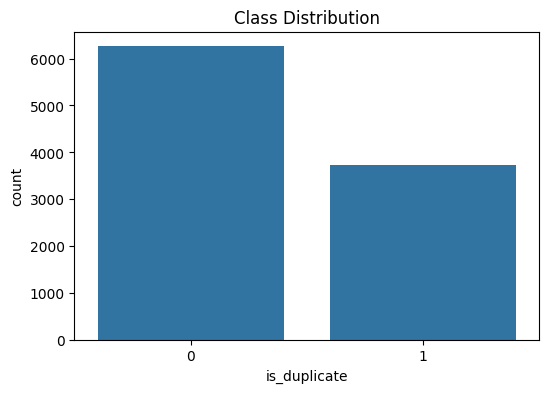

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x=dataset['is_duplicate'])
plt.title("Class Distribution")
plt.show()

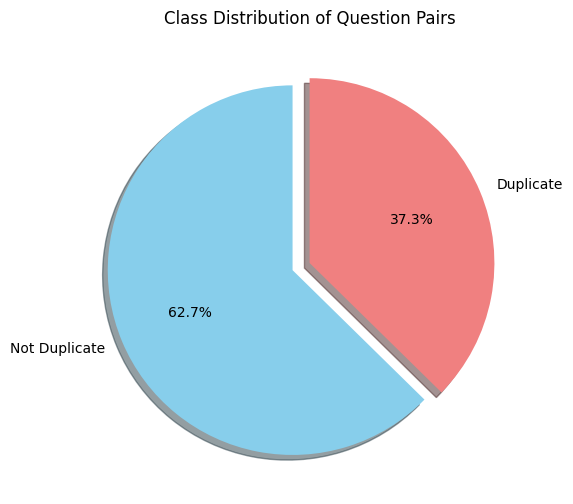

In [20]:
labels = ['Not Duplicate', 'Duplicate']
sizes = dataset['is_duplicate'].value_counts()
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, shadow=True, startangle=90)
plt.title("Class Distribution of Question Pairs")
plt.show()

In [21]:
dataset.rename(columns={'qid1': 'questionId1', 'qid2': 'questionId2'}, inplace=True)

In [22]:
dataset.head(2)

,questionId1,questionId2,question1,question2,is_duplicate
8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0


In [23]:
dataset['is_duplicate'].value_counts()

,count
is_duplicate,
0,6265
1,3735


# Preprocessing

Clean punctuation marks and other special character

In [24]:
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.translate(str.maketrans({'%': ' percent', '$': ' dollar ', '₹': ' rupee ', '€': ' euro ', '@': ' at '}))
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

Expanding the short word to the exact word

In [25]:
def expand_contractions(text):
    contractions_map = {
        "ain't": "am not", "aren't": "are not", "can't": "can not", "can't've": "can not have",
        "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
        "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
        "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
        "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have", "isn't": "is not",
        "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us", "she'd": "she would",
        "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not",
        "that'd": "that would", "that's": "that is", "there's": "there is", "they'd": "they would",
        "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not",
        "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have",
        "weren't": "were not", "what's": "what is", "where's": "where is", "who's": "who is",
        "won't": "will not", "would've": "would have", "wouldn't": "would not", "you're": "you are",
        "you've": "you have", "you'll": "you will", "you'd": "you would"
    }

    words = text.split()
    words = [contractions_map.get(word, word) for word in words]
    return ' '.join(words)

Writing the Final function

In [26]:
def preprocess_text(text):
    text = clean_text(text)
    text = expand_contractions(text)
    return text

Applying the preprocessing step to question

In [27]:
dataset['question1'] = dataset['question1'].astype(str).apply(preprocess_text)
dataset['question2'] = dataset['question2'].astype(str).apply(preprocess_text)

Let's see the dataset value

In [28]:
print(dataset['question1'].values[4])

how close we are to see 3rd world war


In [29]:
dataset.tail(5)

,questionId1,questionId2,question1,question2,is_duplicate
42731,76959,42347,what are the consequences of taking a high dos...,what are the consequences of taking a high dos...,0
141414,224504,224505,how can radioactive pollution be prevented,how can radioactive pollution be controlled,0
93145,155805,155806,im 15 and have dollar 5k i want to start my ow...,im only 15 but my goal is to own a business in...,0
62510,108935,108936,what would you consider the best video games o...,what is your top 10 best video games of all ti...,1
224657,332807,332808,do you think there is a correlation between st...,dual micro sim with single sim version,0


We are using TFIDF for convert the dataset into the numerical value for calculation

In [30]:
vectorizer = TfidfVectorizer(max_features=20000)
x1 = vectorizer.fit_transform(dataset['question1']).toarray()
x2 = vectorizer.transform(dataset['question2']).toarray()

In [31]:
x = np.hstack((x1, x2))
y = dataset['is_duplicate'].values

# Fixing the class imbalance

Previously we have seen that, here in this dataset class imbalance occur. So, now we have to fix this.

In [32]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
x_resampled,y_resampled = rus.fit_resample(x, y)

Let see can we have done the resampling properly or not.

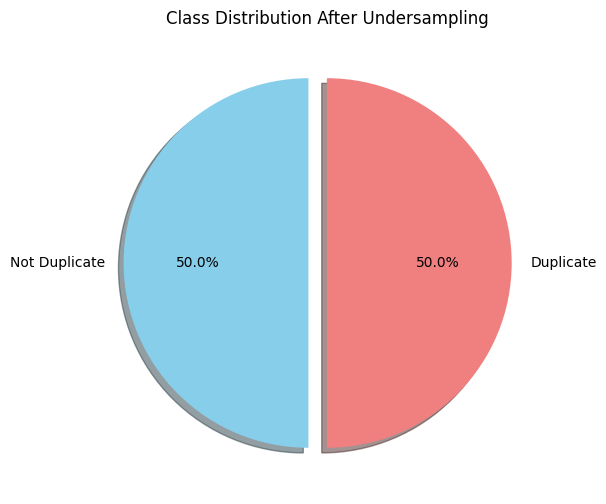

In [33]:
unique, counts = np.unique(y_resampled, return_counts=True)
sizes = dict(zip(unique, counts))
labels = ['Not Duplicate', 'Duplicate']
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)
plt.figure(figsize=(6,6))
plt.pie(sizes.values(), labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, shadow=True, startangle=90)
plt.title("Class Distribution After Undersampling")
plt.show()

# Now, dividing the dataset into Train,Test, Split

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

Build the ANN model for dataset training

In [35]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Train

In [36]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5797 - loss: 0.6744 - val_accuracy: 0.6700 - val_loss: 0.6073
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8416 - loss: 0.3759 - val_accuracy: 0.6539 - val_loss: 0.6997
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9542 - loss: 0.1292 - val_accuracy: 0.6513 - val_loss: 0.9988
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9932 - loss: 0.0254 - val_accuracy: 0.6386 - val_loss: 1.3030
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9989 - loss: 0.0065 - val_accuracy: 0.6466 - val_loss: 1.5967
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.6439 - val_loss: 1.7690
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 0.6466 - val_loss: 1.7760
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 5.7372e-04 - val_accuracy: 0.6519 - 

Model evaluation

In [37]:
Y_pred = model.predict(x_test)
Y_pred = (Y_pred > 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Let's draw the Confusion matrix

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


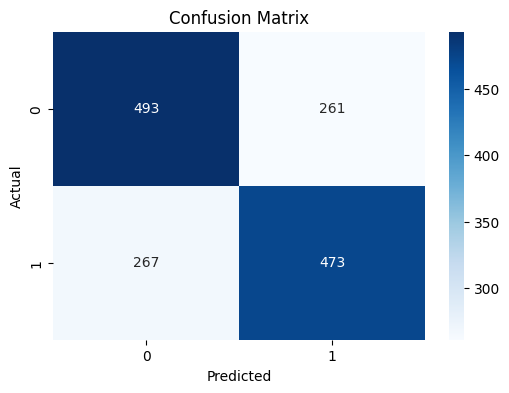

In [38]:
Y_pred = model.predict(x_test)
Y_pred = (Y_pred > 0.5).astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, Y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


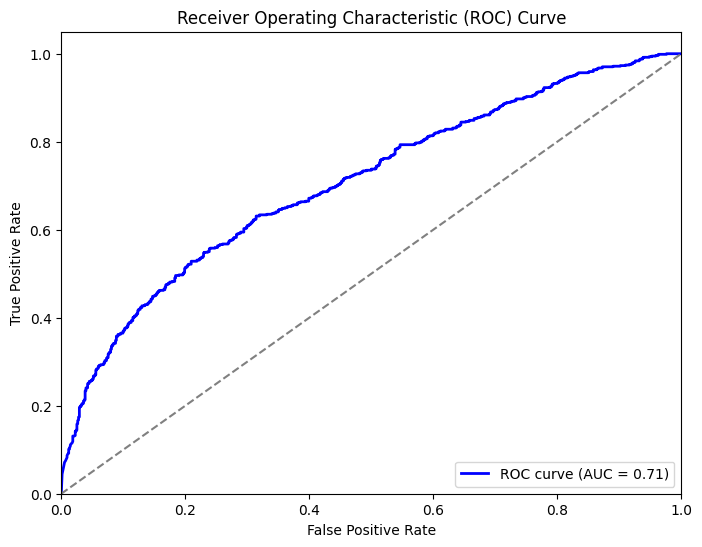

In [41]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
y_prob = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Performing Logistic Regression

In [43]:
lr_reg = LogisticRegression(random_state=42)
lr_reg.fit(x_train, y_train)
y_pred_log_reg = lr_reg.predict(x_test)

Model evaluation of Logistic Regression

In [44]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

Logistic Regression Accuracy: 0.6760374832663989
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.72      0.69       754
           1       0.69      0.63      0.66       740

    accuracy                           0.68      1494
   macro avg       0.68      0.68      0.68      1494
weighted avg       0.68      0.68      0.68      1494



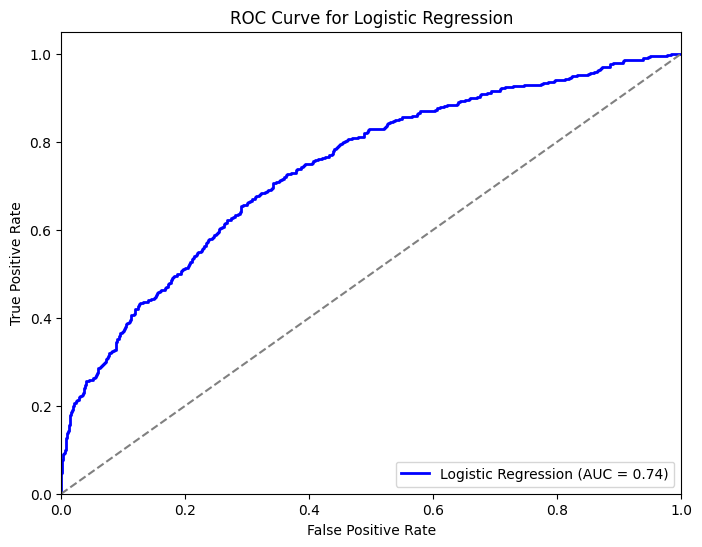

In [46]:
falsePositiveRate_log_reg, truePositiveRate_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(falsePositiveRate_log_reg, truePositiveRate_log_reg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()


# Conclusion

In this project, we developed a machine learning model to classify question pairs as either "duplicate" or "not duplicate" based on semantic similarity. The workflow included exploratory data analysis (EDA), text preprocessing, feature extraction using TF-IDF, and model training with both deep learning and traditional machine learning approaches.

We implemented an artificial neural network (ANN) that showed strong training accuracy but faced generalization challenges, as indicated by the increasing validation loss. To compare performance, we also used logistic regression, which achieved a balanced accuracy but with some trade-offs in precision and recall.

The findings suggest that while deep learning models can capture complex text patterns, they may require additional techniques such as hyperparameter tuning, regularization, or advanced architectures like transformer-based models for better performance. The insights gained from this study can contribute to improving text similarity detection in various NLP applications. Future work could explore dataset augmentation, transfer learning, or alternative model architectures to enhance accuracy further.

